In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re

import tifffile
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [67]:
WORKDIR='/home/daniel/gdrive/EPFL/2019-2020/MachineLearning/Project/gravitational_lens_ml'
SRC = os.path.join(WORKDIR, 'src')
DATA = os.path.join(WORKDIR,'data')
RESULTS = os.path.join(WORKDIR, 'results')
TRAIN = os.path.join(DATA, 'datapack2.0train/Public')
TEST = os.path.join(DATA, 'datapack2.0test/Public')
TRAIN_MULTIBAND = os.path.join(DATA, 'train_multiband')
TEST_MULTIBAND = os.path.join(DATA, 'test_multiband')

In [68]:
image_catalog = pd.read_csv(os.path.join(DATA, 'catalog/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [69]:
band = 'EUC_VIS'
def get_file_id(filename, delimiters = '_|\.|-'):
    id_ = [int(s) for s in re.split(delimiters, filename) if s.isdigit()][0]
    return id_
file_id_train = np.array([get_file_id(f) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
file_id_test = np.array([get_file_id(f) for f in os.listdir(os.path.join(TEST, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
missing_img =  np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False)
print(file_id_train.shape)
print(missing_img)

(99991,)
[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [70]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [71]:
image_catalog['img_exists'] = True
image_catalog['img_exists'].loc[image_catalog['ID'].isin(missing_img)] = False

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0


/home/daniel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [72]:
image_catalog = image_catalog.drop_duplicates('ID')
image_catalog[['ID',
               'is_lens']][image_catalog['img_exists']].to_csv(os.path.join(
                   RESULTS, 'lens_id_labels.csv'),
                                                               index=False)

In [73]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [74]:
def get_image_filename_from_id(id_, band, set_ = TRAIN, ext = 'fits'):
    fname = os.path.join(set_, '{0}/image{0}-{1}.{2}'.format(band, id_, ext))
    return fname
def plot_all_bands_from_id(id_):
    fig = plt.figure(figsize=(20, 6))
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(aplpy.FITSFigure(data[i], figure=fig, subplot=(1,4,i+1)))
        fitsfigs[i].show_colorscale()
        fitsfigs[i].set_theme('preety')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()
    fig.tight_layout() 
with fits.open(get_image_filename_from_id(290000, 'EUC_VIS')) as hdu1:
    with fits.open(get_image_filename_from_id(290000, 'EUC_H')) as hdu2:
        data1 = hdu1[0].data
        data2 = hdu2[0].data
        data2_reprojected, data2_footprint = reproject_interp(hdu2[0], hdu1[0].header)


/home/daniel/anaconda3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -2.832e-12 [aplpy.core]
INFO: Auto-setting vmax to  1.416e-11 [aplpy.core]


INFO: Auto-setting vmin to -1.236e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.096e-09 [aplpy.core]


INFO: Auto-setting vmin to -8.179e-11 [aplpy.core]
INFO: Auto-setting vmax to  6.074e-10 [aplpy.core]


INFO: Auto-setting vmin to -1.043e-10 [aplpy.core]
INFO: Auto-setting vmax to  8.215e-10 [aplpy.core]


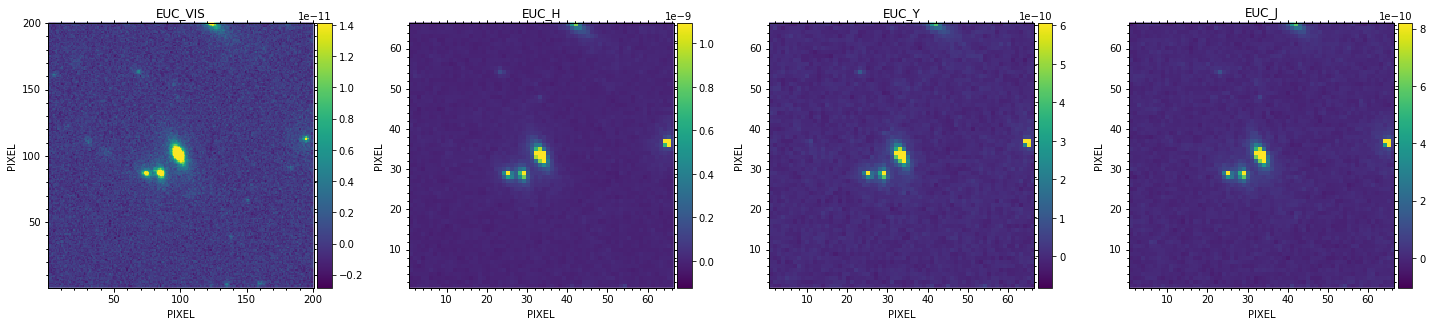

In [75]:
plot_all_bands_from_id(270610)

# Combine bands into `tiff` and test

In [76]:
def build_image(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        interval = AsymmetricPercentileInterval(0.25, 99.75, n_samples=10000)
        vmin, vmax = interval.get_limits(band_data)
        stretch = MinMaxInterval() +  LogStretch()
        data[:,:,i] = stretch(((np.clip(band_data, vmin*(-0.7), vmax))/(vmax)))
    for t in tables:
        t.close()
    return data.astype(np.float32)


/home/daniel/anaconda3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


640128
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
2033    True
Name: is_lens, dtype: bool


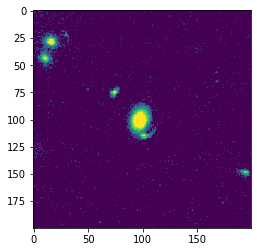

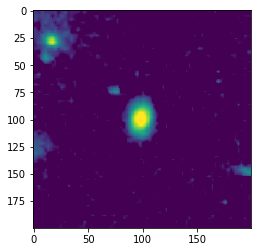

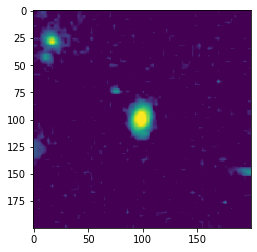

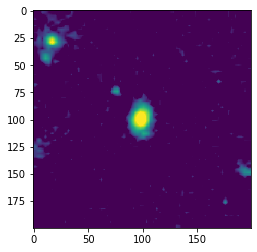

In [77]:
img = build_image(270210, TRAIN)
print(sys.getsizeof(img))
for i in range(4):
    plt.figure()
    print(np.min(img[:,:,i]), np.max(img[:,:,i]))
    a = plt.imshow((img[:,:,i]))
print(image_catalog.loc[image_catalog['ID']==270210]['is_lens'])

# Compare preprocessing with Log + Norm

In [78]:
def build_image_noprocess(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        norm =  LogStretch()
        data[:,:,i] = norm(band_data)
    for t in tables:
        t.close()
    return data.astype(np.float32)


In [79]:
test_id = 200004
img = build_image(test_id, TRAIN)
img_nopr = build_image_noprocess(test_id, TRAIN)
def plot_slice(image, slice_ratio, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.
    slice_ratio: float from 0 to 1 where 0 is the top slice, and 1 is the last slice.
    axis: 0 or 1 to show horizontal or vertical slices'''
    
    index = int(image.shape[axis] * slice_ratio)
    slice_ = image[index]
    plt.plot(slice_)


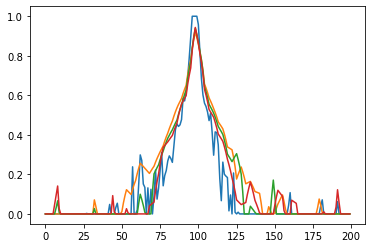

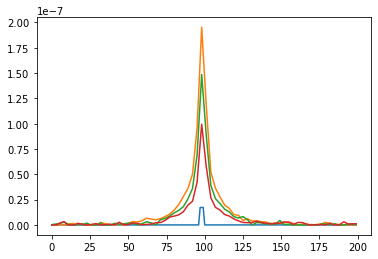

In [80]:
plot_slice(img, 0.5)
plt.figure()
plot_slice(img_nopr, 0.5)

In [81]:
def plot_slice_stack(image, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.'''
    
    slice_ = np.sum(image, axis=axis)
    print(slice_.shape)
    plt.plot(slice_)

(200, 4)
(200, 4)


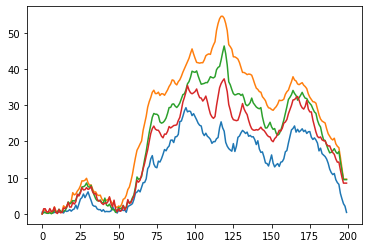

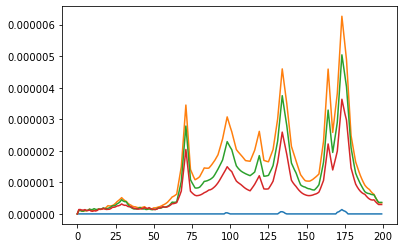

In [82]:
axis = 0
plot_slice_stack(img, axis = axis)
plt.figure()
plot_slice_stack(img_nopr, axis = axis)

In [83]:
from __future__ import absolute_import, division, print_function, unicode_literals
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)


Num GPUs Available:  0


# PCA

In [84]:
img = tifffile.imread(DATA+'/train_multiband/image_299896_multiband.tiff')
def flatten_by_channel(original_image):
    """preprocess the image."""
    n_channels = original_image.shape[-1]
    processed_image = original_image.reshape(-1,n_channels)
    return processed_image.astype(np.float32) #Overflow if using unsigned int
flat_img = flatten_by_channel(img)


In [85]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA(whiten=False)
std_flat_img = scaler.fit_transform(flat_img)
pca.fit(std_flat_img)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 4 artists>

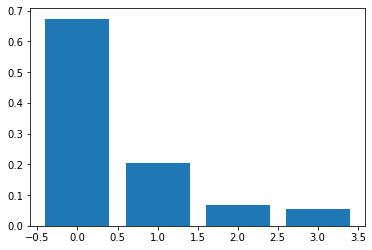

In [86]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [87]:
pca_flat_img = pca.fit_transform(std_flat_img)
pca_image = pca_flat_img.reshape((img.shape[0], img.shape[1], -1))

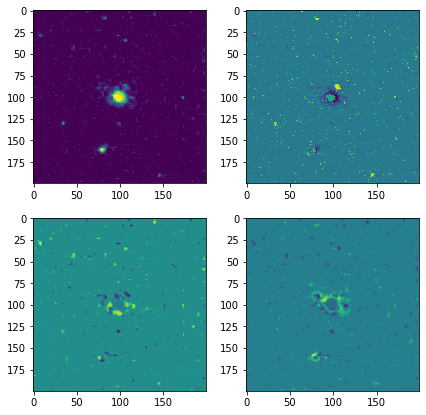

In [88]:
f, ax = plt.subplots(2, 2, figsize = (7, 7))
for i, a in enumerate(ax.ravel()):
    a.imshow(pca_image[:,:,i])

## Covariance Matrix between colors
See, that it is almost diagonal. Not surprising that PC's are almost the same as the priginal colors.

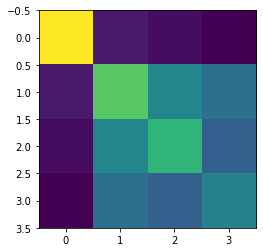

In [89]:
plt.imshow(np.cov(flat_img.T))

# Test  CNN

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, Iterator
from sklearn.model_selection import train_test_split

In [91]:
# From Tensorflow examples
batch_size = 24
epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 200


In [92]:
lens_df = pd.read_csv(os.path.join(RESULTS, 'lens_id_labels.csv'), index_col = 0)
local_test_files = os.listdir(TRAIN_MULTIBAND)
local_test_id = [
    get_file_id(filename)
    for filename in local_test_files
]
local_test_df = pd.DataFrame()
local_test_df['filenames'] = local_test_files
local_test_df['labels'] = lens_df.loc[local_test_id, 'is_lens'].values.astype(int)
train_df, val_df = train_test_split(local_test_df, test_size=0.1, random_state=42)
total_train = len(train_df)
total_val = len(val_df)

In [93]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,4)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [94]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 16)      592       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)       

In [95]:
class TiffImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super(TiffImageDataGenerator, self).__init__(*args, **kwargs)
    def get_input(self, path):
        img = tifffile.imread(path)
        return img
    def image_generator_dataframe(self,dataframe,
                              directory='',
                              x_col='filename',
                              y_col='class',
                              batch_size=64,
                              validation=False):
        files = dataframe[x_col].values
        while True:
            # Select files (paths/indices) for the batch
            batch_paths = np.random.choice(a=files, size=batch_size)
            batch_input = []
            batch_output = []

            # Read in each input, perform preprocessing and get labels
            for input_path in batch_paths:
                input = self.get_input(os.path.join(directory, input_path))
                output = dataframe[dataframe[x_col] == input_path][y_col].values[0]
                if self.preprocessing_function:
                    input = self.preprocessing_function(input)
                if not validation:
                    input = self.random_transform(input)
                batch_input += [input]
                batch_output += [output]
            # Return a tuple of (input,output) to feed the network
            batch_x = np.array(batch_input)
            batch_y = np.array(batch_output)

            yield (batch_x, batch_y)
    

In [96]:
image_data_gen_train = TiffImageDataGenerator(featurewise_center=False,
                                          samplewise_center=False,
                                          featurewise_std_normalization=False,
                                          samplewise_std_normalization=False,
                                          zca_whitening=False,
                                          zca_epsilon=1e-06,
                                          rotation_range=20,
                                          width_shift_range=0.0,
                                          height_shift_range=0.0,
                                          brightness_range=(0.8, 1.1),
                                          shear_range=0.0,
                                          zoom_range=(0.9, 1.1),
                                          channel_shift_range=0.0,
                                          fill_mode='nearest',
                                          cval=0.0,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rescale=None,
                                          preprocessing_function=None,
                                          data_format='channels_last',
                                          validation_split=0.2,
                                          dtype='float32')
image_data_gen_val = TiffImageDataGenerator(dtype='float32')

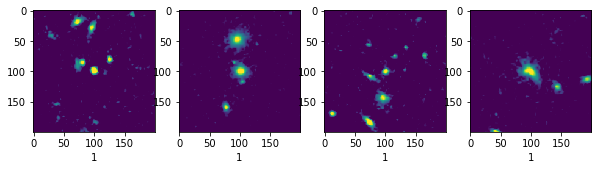

In [97]:
train_data_gen = image_data_gen_train.image_generator_dataframe(train_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                 y_col='labels', batch_size = 1, validation=False)
val_data_gen = image_data_gen_val.image_generator_dataframe(train_df,
                                  directory=TRAIN_MULTIBAND,
                                  x_col='filenames',
                                 y_col='labels', batch_size = 1, validation=True)
fig, ax = plt.subplots(1,4, figsize = (10, 2.5))
for a in ax.ravel():
    img, label = next(train_data_gen)
    a.imshow(img[0][:,:,2])
    a.set_xlabel(label[0])


In [98]:
checkpoint_path = os.path.join(RESULTS, 'checkpoints/simple_cnn/simple_cnn.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val,
    callbacks = [cp_callback]
    
)
model.save(os.path.join(RESULTS,'simple_cnn.h5'))




Epoch 1/15
 260/9908 [..............................] - ETA: 43:36 - loss: 1.0026 - accuracy: 0.9346

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
